### Calculating average return is not a complete method to evaluate performance of a portfolio. We use many different performance and risk metrics to compare two different portfolios.
### Let's get the data first!

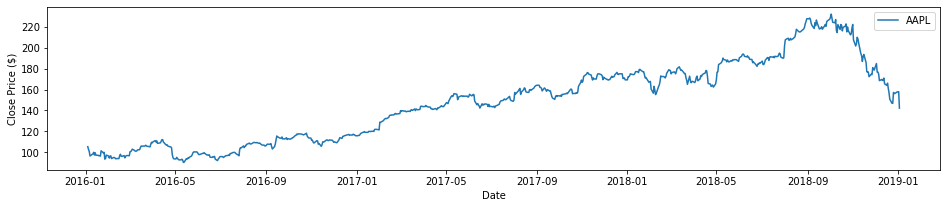

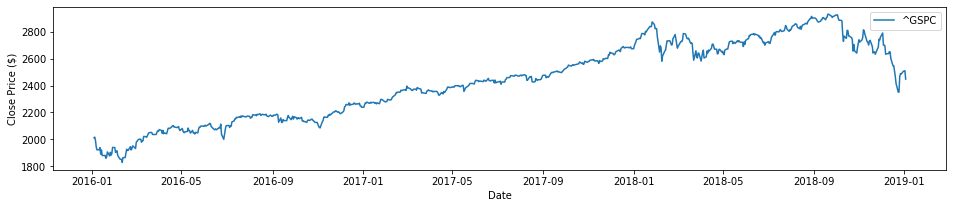

In [2]:
# Load the data time series to be used below
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

def get_data( ticker, start_date, end_date ):
    data = pdr.DataReader( ticker, 'yahoo', start_date, end_date );
    data = data['Close'];
    # we got the data, now we need to clean it up and fill the NaNs
    all_valid_days = pd.date_range( start = start_date, end = end_date, freq = 'B' )
    data = data.reindex( all_valid_days )  # have data entries for all these days
    data = data.fillna( method = 'ffill' ) # fill NaNs with last valid value
    return data;

def plot_price_series( ticker, series ):
    _, ax = plt.subplots(figsize=(16,3))
    ax.plot(series.index, series, label=ticker)
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price ($)')
    ax.legend()
    plt.show()

asset_symbol = 'AAPL' # Apple ticker
bchmk_symbol = '^GSPC' # S&P 500
start_date = '01-03-2016'
end_date = '01-03-2019'
risk_free_rate = 0.03
asset_prices_df = get_data( asset_symbol, start_date, end_date )
asset_prices_array = np.array( asset_prices_df );

bchmk_prices_df = get_data( bchmk_symbol, start_date, end_date )
bchmk_prices_array = np.array( bchmk_prices_df );

plot_price_series( asset_symbol, asset_prices_df )
plot_price_series( bchmk_symbol, bchmk_prices_df )

### It seems we got two series that are pretty correlated! Let's check if we can consider them as pair for asset and its benchmark.

In [3]:
from sklearn import linear_model

def getRSquared( asset_price, benchmark_price ):
    """
    Returns rSquared value of asset and its benchmark's price series
    
    rSquared is statistical measure that, in this case, measures percentage of asset price movements
    that can be explained by percentage of movements in benchmark index
    """
    #build a regression model
    lrModel = linear_model.LinearRegression().fit( [ [x] for x in benchmark_price], [ [x] for x in asset_price] );
    asset_predicted_price = benchmark_price*lrModel.coef_[0][0] + lrModel.intercept_;
    #calculate r^2
    explained_variance = np.sum(( asset_predicted_price- asset_price )**2);
    total_variance = np.sum(( asset_predicted_price - np.mean( asset_price ))**2);
    r_squared = 1 - (explained_variance/total_variance);
    return r_squared
    
print('Looking into price series for asset {} from {} to {} considering {} as benchmark when needed'.format(
    asset_symbol, start_date, end_date, bchmk_symbol ));
r_squared = getRSquared( asset_prices_array, bchmk_prices_array )
print('R^2 : {0:10.3f}'.format( r_squared ) )

Looking into price series for asset AAPL from 01-03-2016 to 01-03-2019 considering ^GSPC as benchmark when needed
R^2 :      0.918


In [4]:
def variance( series ):
    """
    It calculates variance of asset prices.
    This variance is indicator of volatility of the asset.
    """
    return np.var( series );

def maximum_drawdown( series ):
    """
    A drawdown is a peak-to-trough decline for given asset price series.
    Maximum drawdown is difference between highest peak and lowest trough
    in a given time series.
    """
    [ maximum_val, minimum_val ] = [ np.max( series ), np.min( series ) ]
    maximum_drawdown = ( maximum_val - minimum_val )/maximum_val;
    return maximum_drawdown;

def covariance( series1, series2 ):
    """
    Returns covariance of two given time series
    numpy.cov( x, y ) returns [ [ variance(x), cov( x, y) ], [ cov( x, y), variance( y) ] ]
    """
    return np.cov( series1, series2 )[0][1]; #[1][0] would have worked as well

def correlation_coefficient( series1, series2 ):
    """
    Correlation coefficient is covariance divided by std deviation of the time series
    """
    return covariance( series1, series2 )/(np.std(series1)*np.std(series2));

print('Looking into price series for asset {} from {} to {} considering {} as benchmark when needed'.format(
    asset_symbol, start_date, end_date, bchmk_symbol ));
print('Variance : {0:10.3f}'.format( variance( asset_prices_array ) ) )
print('Maximum Drawdown : {0:10.3f}'.format(maximum_drawdown( asset_prices_array ) ))
print('Covariance between asset and its benchmark : {0:10.3f}'.format( covariance( asset_prices_array, bchmk_prices_array )))
print('Correlation coefficient between asset and its benchmark : {0:10.3f}'.format(
    correlation_coefficient( asset_prices_array, bchmk_prices_array )))

Looking into price series for asset AAPL from 01-03-2016 to 01-03-2019 considering ^GSPC as benchmark when needed
Variance :   1411.846
Maximum Drawdown :      0.611
Covariance between asset and its benchmark :  10315.012
Correlation coefficient between asset and its benchmark :      0.962


#### Note that correlation coefficient between chosen asset and benchmark is pretty close to 1, suggesting these assets are pretty correlated!
### Now let's look at the alpha, beta, sharpe ratio and other performance measures of asset as compared to its benchmark

In [5]:
def calc_return( series ):
    return ( series[-1] - series[0] )/ series[0];

def alpha( asset_price, benchmark_price ):
    """
    Alpha is measure of excess return of portfolio with respect to returns in benchmark.
    Idea is to try to beat the market ( benchmark ) i.e. active investing. 
    """
    if( asset_price[0] == 0 ):
        raise ValueError('Initial price for asset is 0');
    if( benchmark_price[0] == 0 ):
        raise ValueError('Initial price for benchmark is 0');
    return_of_asset = calc_return( asset_price );
    return_of_market = calc_return( benchmark_price );
    alpha = return_of_asset - return_of_market;
    return alpha;

def beta( asset_price, benchmark_price ):
    """
    Beta is measure of volatility of investment as compared to market
    i.e. how large changes are in investment price compared to one in market price
    """
    beta = covariance( asset_price, benchmark_price )/variance( benchmark_price );
    return beta;

def jensen_alpha( asset_price, benchmark_price, risk_free_rate ):
    """
    This measure leverages CAPM ( Capital Asset Pricing model )
    Idea is that expected return of an investment = time value (+) risk value 
    i.e. Risk free rate (+) beta of investment * ( expected market return - risk free rate)
    """
    if( asset_price[0] == 0 ):
        raise ValueError('Initial price for asset is 0');
    if( benchmark_price[0] == 0 ):
        raise ValueError('Initial price for benchmark is 0');
    return_of_asset = calc_return( asset_price );
    return_of_market = calc_return( benchmark_price );
    
    beta_of_investment = beta( asset_price, benchmark_price );
    expected_return_of_investment = risk_free_rate + \
        beta_of_investment*( return_of_market - risk_free_rate );
    jensen_alpha = return_of_asset - expected_return_of_investment;
    return jensen_alpha;

def sharpe_ratio( asset_price, risk_free_rate ):
    """
    This is measure of how much excess return one receives for the extra volatility (risk) of asset
    Sharpe Ratio = ( Avg return of asset - Risk free rate )/Standard Deviation( asset )
    A good strategy has sharpe ratio value > 2
    It assumes returns are normally distributed - and doesn’t consider tail risk
    It also assumes that future would be repetition of past - which is not always true
    It also ignores volatility direction. ( hence Sortino ratio )
    It does not account for maximum drawdown ( hence Calmer ratio )
    """
    if( asset_price[0] == 0 ):
        raise ValueError('Initial price for asset is 0');
    return_of_asset = calc_return( asset_price )
    numerator = return_of_asset - risk_free_rate;
    denominator = np.std( asset_price );
    return numerator/denominator;

def sortino_ratio( asset_price, risk_free_rate ):
    """
    This ratio takes standard deviation of negative returns only i.e. prices < price we invested our asset at
    We assume first investment price is where we invested in.
    """
    if( asset_price[0] == 0 ):
        raise ValueError('Initial price for asset is 0');
    return_of_asset = calc_return( asset_price )
    numerator = return_of_asset - risk_free_rate;
    denominator = np.std( [ x for x in asset_price if x < asset_price[0] ] );
    return numerator/denominator;

def calmer_ratio( asset_price, risk_free_rate ):
    """
    It assumes price series is over 3 years - and we divide it in three subsets 
    and calculate for each, the annual rate of return
    Average annual rate of return/ maximum drawdown - usually calculated over 3 years
    A high value of the ratio indicates that investment's return
    has not been at risk of large drawdowns
    """
    len_subset = (int)(len(asset_price)/3);
    subsets = [ asset_price[i*len_subset:(i+1)*len_subset] for i in range(0,3)];
    average_annual_rate_of_return = np.mean( [ calc_return(subset) for subset in subsets ]);
    max_drawdown = maximum_drawdown( asset_price )
    return average_annual_rate_of_return/max_drawdown;


print('Looking into price series for asset {} from {} to {} considering {} as benchmark when needed'.format(
    asset_symbol, start_date, end_date, bchmk_symbol ));
print('Alpha : {0:10.3f}'.format( alpha( asset_prices_array, bchmk_prices_array ) ) )
print('Beta : {0:10.3f}'.format( beta( asset_prices_array, bchmk_prices_array ) ) )
print('Jensen Alpha : {0:10.3f}'.format( jensen_alpha( asset_prices_array, bchmk_prices_array, risk_free_rate )))
print('Sharpe Ratio : {0:10.3f}'.format( sharpe_ratio( asset_prices_array, risk_free_rate )))
print('Sortino Ratio : {0:10.3f}'.format( sortino_ratio( asset_prices_array, risk_free_rate )))
print('Calmer Ratio : {0:10.3f}'.format( calmer_ratio( asset_prices_array, risk_free_rate )))

Looking into price series for asset AAPL from 01-03-2016 to 01-03-2019 considering ^GSPC as benchmark when needed
Alpha :      0.133
Beta :      0.127
Jensen Alpha :      0.296
Sharpe Ratio :      0.009
Sortino Ratio :      0.099
Calmer Ratio :      0.273


### Let's calculate value-at-risk ( VaR ) now. Value at risk is a statistic that measures the level of financial risk of position over given time frame.

In [6]:
import random;

def value_at_risk( symbol, asset_price ):
    print( 'VaR for symbol', symbol )
    confidence_level_to_std_dev_scale = {0.95:-1.65,0.99:-2.33};

    # 1. historical method
    daily_returns = [ (asset_price[i]-asset_price[i-1])/asset_price[i-1] for i in range(1,len(asset_price)) ];
    daily_returns.sort();
    value_at_risk = {};
    for confidence_level in confidence_level_to_std_dev_scale:
        var = daily_returns[ (int)(len(daily_returns)*(1-confidence_level)) ];
        value_at_risk[ confidence_level ] = round(var*100,2); #in percentage values
    print('\tUsing historical method for different confidence level : ', value_at_risk);

    # 2. variance-covariance method
    # Uses a normal distributed curve and known multiple of stdDev to find out the return with needed confidence
    std_dev = np.std( daily_returns );
    value_at_risk = {};
    for confidence_level in confidence_level_to_std_dev_scale:
        var = confidence_level_to_std_dev_scale[ confidence_level ]*std_dev;
        value_at_risk[ confidence_level ] = round(var*100,2); #in percentage values
    print('\tUsing variance-covariance method for different confidence level : ', value_at_risk);

    # 3. monte carlo simulation
    daily_returns = [];
    for iteration in range(0,1000):
        i = random.randint(1,len(asset_price)-1);
        daily_returns.append( (asset_price[i] - asset_price[i-1])/asset_price[i-1] );
    daily_returns.sort();
    value_at_risk = {};
    for confidence_level in confidence_level_to_std_dev_scale:
        var = daily_returns[ (int)(len(daily_returns)*(1-confidence_level)) ];
        value_at_risk[ confidence_level ] = round(var*100,2); #in percentage values
    print('\tUsing monte carlo simulation for different confidence level : ', value_at_risk);

def conditional_var( symbol, asset_price ):
    """
    Expected value at risk once VaR limit is crossed
    """
    daily_returns = [ (asset_price[i]-asset_price[i-1])/asset_price[i-1] for i in range(1,len(asset_price)-1) ];
    daily_returns.sort();
    conditional_value_at_risk = {};
    for confidence_level in [ 0.95, 0.99 ]:
        index = (int)(len(daily_returns)*(1-confidence_level));
        cvar = np.mean( daily_returns[0:index] );
        conditional_value_at_risk[ confidence_level ] = round(cvar*100,2)
    print('CVaR for symbol ', symbol, 
          'using historical method for different confidence level : ', conditional_value_at_risk );

value_at_risk( asset_symbol, asset_prices_array)
conditional_var( asset_symbol, asset_prices_array)

VaR for symbol AAPL
	Using historical method for different confidence level :  {0.95: -2.5, 0.99: -4.4}
	Using variance-covariance method for different confidence level :  {0.95: -2.49, 0.99: -3.51}
	Using monte carlo simulation for different confidence level :  {0.95: -2.56, 0.99: -4.22}
CVaR for symbol  AAPL using historical method for different confidence level :  {0.95: -3.49, 0.99: -5.47}
